In [ ]:
#-----main code starts here------------------------------------

In [2]:
# ---------------------------------------------------------
# Code Cell 1: Exploratory Data Analysis (EDA) & Data Understanding
# ---------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
import time

start_eda = time.time()  # Start timer for EDA
# Load the dataset (we now assume the data is in CSV format)
data = pd.read_csv('1year.csv')
df = pd.DataFrame(data)


# Print basic dataset information
print("Dataset shape:", df.shape)
print("Dataset columns:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

# Display detailed info and summary statistics
print("\nData Info:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())

# Identify numeric columns for visualization
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# # Plot histograms for the first few numeric columns to inspect distributions
# for col in numeric_cols[:5]:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(df[col].dropna(), kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()

# # Optional: Correlation heatmap for numeric features
# plt.figure(figsize=(12, 10))
# corr = df[numeric_cols].corr()
# sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title("Correlation Heatmap of Numeric Features")
# plt.show()

end_eda = time.time()  # End timer for EDA
print("Total EDA Execution Time: {:.2f} seconds".format(end_eda - start_eda))

Dataset shape: (7027, 65)
Dataset columns: ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'class']

First 5 rows:
      Attr1    Attr2    Attr3   Attr4    Attr5    Attr6     Attr7    Attr8  \
0  0.200550  0.37951  0.39641  2.0472  32.3510  0.38825  0.249760  1.33050   
1  0.209120  0.49988  0.47225  1.9447  14.7860  0.00000  0.258340  0.99601   
2  0.248660  0.69592  0.26713  1.5548  -1.1523  0.00000  0.309060  

In [3]:
# ---------------------------------------------------------
# Code Cell 2: Category-Specific Data Preprocessing (Updated for Both Training and Test)
# ---------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


start_preprocessing = time.time()  # Start overall preprocessing timer

# Ensure column names are clean
df.columns = df.columns.str.strip()
print("Columns after stripping:", df.columns.tolist())

# Perform train-test split (make sure these variables are global)
X = df.drop(columns=['class'])
y = df['class']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train_full.shape)
print("Test set shape:", X_test_full.shape)

# Define the grouping of features by category.
group_features = {
    "Profitability": ['Attr1', 'Attr6', 'Attr7', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 
                      'Attr16', 'Attr18', 'Attr19', 'Attr22', 'Attr23', 'Attr24', 'Attr26', 
                      'Attr31', 'Attr35', 'Attr39', 'Attr42', 'Attr48', 'Attr49', 'Attr56'],
    "Leverage":      ['Attr2', 'Attr8', 'Attr10', 'Attr17', 'Attr25', 'Attr38', 'Attr51', 
                      'Attr53', 'Attr54', 'Attr59'],
    "Liquidity":     ['Attr3', 'Attr4', 'Attr5', 'Attr28', 'Attr37', 'Attr40', 'Attr46', 
                      'Attr50', 'Attr55', 'Attr57'],
    "Efficiency":    ['Attr9', 'Attr15', 'Attr20', 'Attr27', 'Attr30', 'Attr32', 'Attr33', 
                      'Attr34', 'Attr36', 'Attr41', 'Attr43', 'Attr44', 'Attr45', 'Attr47', 
                      'Attr52', 'Attr58', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64'],
    "GrowthSize":    ['Attr21', 'Attr29']
}

# Initialize a dictionary to store fitted scalers for each group.
scalers = {group: None for group in group_features}

def process_category_df(df_cat, scaler=None, fit_scaler=False, target_col=None, quantile_thresholds=None):
    """
    Process a DataFrame for a given category.
      - One-hot encodes categorical columns.
      - Imputes missing numeric values with -999.
      - Caps outliers using 1st and 99th percentiles.
         * If quantile_thresholds is None, compute them (training data).
         * Otherwise, use the provided thresholds.
      - Scales numeric features using MinMaxScaler.
    Returns the processed DataFrame, the scaler, and the quantile thresholds.
    """
    features_df = df_cat.copy()
    
    # Separate target column if provided.
    if target_col and target_col in features_df.columns:
        target_series = features_df[target_col]
        features_df = features_df.drop(columns=[target_col])
    else:
        target_series = None
    
    # One-hot encode categorical columns.
    categorical_cols = features_df.select_dtypes(include=['object']).columns.tolist()
    if categorical_cols:
        features_df = pd.get_dummies(features_df, columns=categorical_cols, drop_first=True)
    
    # Identify numeric columns.
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Impute missing numeric values.
    features_df[numeric_cols] = features_df[numeric_cols].fillna(-999)
    
    # Outlier capping: compute thresholds on training data or use provided thresholds.
    if quantile_thresholds is None:
        quantile_thresholds = {}
        for col in numeric_cols:
            lower = features_df[col].quantile(0.01)
            upper = features_df[col].quantile(0.99)
            quantile_thresholds[col] = (lower, upper)
            features_df[col] = features_df[col].clip(lower, upper)
    else:
        for col in numeric_cols:
            if col in quantile_thresholds:
                lower, upper = quantile_thresholds[col]
                features_df[col] = features_df[col].clip(lower, upper)
            else:
                # Optionally compute new thresholds (or leave as is)
                lower = features_df[col].quantile(0.01)
                upper = features_df[col].quantile(0.99)
                quantile_thresholds[col] = (lower, upper)
                features_df[col] = features_df[col].clip(lower, upper)
    
    # Scale numeric columns.
    if numeric_cols:
        if fit_scaler:
            scaler = MinMaxScaler().fit(features_df[numeric_cols])
        features_df[numeric_cols] = scaler.transform(features_df[numeric_cols])
    
    # Add target back if it was removed.
    if target_series is not None:
        features_df[target_col] = target_series.values
        
    return features_df, scaler, quantile_thresholds

start_train_preprocessing = time.time()  # Start timer for training preprocessing

# ---------------------------
# Process and Check Training Data by Category
# ---------------------------
processed_group_dfs_train = {}
scalers = {}
quantile_thresholds_dict = {}

print("----- Processing Training Data by Category -----")
for group, feats in group_features.items():
    subset_features = X_train_full[feats].copy()
    subset_target = y_train_full.reset_index(drop=True)
    subset_df = pd.concat([subset_features.reset_index(drop=True), subset_target], axis=1)
    print(f"Before processing for {group}: {subset_df.shape}")
    
    processed_df, fitted_scaler, quantile_thresholds = process_category_df(
        subset_df, scaler=None, fit_scaler=True, target_col='class', quantile_thresholds=None
    )
    scalers[group] = fitted_scaler
    quantile_thresholds_dict[group] = quantile_thresholds
    processed_group_dfs_train[group] = processed_df
    print(f"After processing for {group}: {processed_df.shape}")

end_train_preprocessing = time.time()  # End timer for training preprocessing
print("Training Data Preprocessing Time: {:.2f} seconds".format(end_train_preprocessing - start_train_preprocessing))
# ---------------------------
# Process and Check Test Data by Category
# ---------------------------

start_test_preprocessing = time.time()  # Start timer for test preprocessing

processed_group_dfs_test = {}
print("\n----- Processing Test Data by Category -----")
for group, feats in group_features.items():
    subset_features = X_test_full[feats].copy()
    subset_target = y_test_full.reset_index(drop=True)
    subset_df = pd.concat([subset_features.reset_index(drop=True), subset_target], axis=1)
    print(f"Before processing for {group}: {subset_df.shape}")
    
    processed_df, _ , _ = process_category_df(
        subset_df, 
        scaler=scalers[group], 
        fit_scaler=False, 
        target_col='class', 
        quantile_thresholds=quantile_thresholds_dict[group]
    )
    processed_group_dfs_test[group] = processed_df
    print(f"After processing for {group}: {processed_df.shape}")
    
end_test_preprocessing = time.time()  # End timer for test preprocessing
print("Test Data Preprocessing Time: {:.2f} seconds".format(end_test_preprocessing - start_test_preprocessing))

end_preprocessing = time.time()  # End overall preprocessing timer
print("Total Preprocessing Execution Time: {:.2f} seconds".format(end_preprocessing - start_preprocessing))

Columns after stripping: ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64', 'class']
Training set shape: (5621, 64)
Test set shape: (1406, 64)
----- Processing Training Data by Category -----
Before processing for Profitability: (5621, 22)
After processing for Profitability: (5621, 22)
Before processing for Leverage: (5621, 11)
After processing for Leverage: (5621, 11)
Before processing for Liquidity: (5621, 11)
Aft

In [40]:
import pandas as pd

# Read the CSV file
df_count = pd.read_csv('1year.csv')

# Compute the percentage of each value (0's and 1's) in the 'class' column
percentages = df_count['class'].value_counts(normalize=True) * 100

# Optionally, round the percentages to a desired number of decimal places
percentages = percentages.round(2)

print(percentages)

0    96.14
1     3.86
Name: class, dtype: float64


In [41]:
counts = df_count['class'].value_counts()
print(counts)

0    6756
1     271
Name: class, dtype: int64


In [42]:
import pandas as pd
from scipy.io import arff

# Load the ARFF file
data1, meta1 = arff.loadarff('1year.arff')
df_count = pd.DataFrame(data1)

# If values in the 'class' column are byte strings, decode them
if df_count['class'].dtype == object:
    df_count['class'] = df_count['class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Count the occurrences in the 'class' column
counts = df_count['class'].value_counts()

# Convert counts to percentages
percentages = (counts / counts.sum()) * 100

# Optionally, round the percentages to two decimal places
percentages = percentages.round(2)

# Print the results
print(percentages)


0    96.14
1     3.86
Name: class, dtype: float64


In [43]:
df_count.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [3]:
# ---------------------------------------------------------
# Code Cell 3 (main): Base Model Training, Model Selection, and Meta-Model Training
# ---------------------------------------------------------
import os
import time
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import logging

# 0. Configure logging globally
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger()

# --- Configuration ---
NFOLDS    = 5
SEED      = 42
N_JOBS    = -1
MODEL_DIR = "enhanced_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Model Configurations (unchanged) ---
model_configs = {
    "XGBoost": {
        "model": xgb.XGBClassifier,
        "params": {
            "learning_rate": 0.05, "n_estimators": 200, "max_depth": 4,
            "subsample": 0.8, "colsample_bytree": 0.8,
            "objective": "binary:logistic", "n_jobs": N_JOBS,
            "random_state": SEED
        },
        "tune_params": {"max_depth": (3, 10), "learning_rate": (0.01,0.3), "n_estimators": (50,300)}
    },
    "GBDT": {
        "model": GradientBoostingClassifier,
        "params": {
            "learning_rate": 0.05, "n_estimators": 200, "max_depth": 4,
            "subsample": 0.8, "random_state": SEED
        },
        "tune_params": {"max_depth": (3, 10), "learning_rate": (0.01,0.3), "n_estimators": (50,300)}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier,
        "params": {"n_estimators":200, "learning_rate":0.05, "random_state":SEED},
        "tune_params": {"n_estimators": (50,300), "learning_rate": (0.01,1.0)}
    },
    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {
            "n_estimators":200, "max_depth":12, "max_features":0.2,
            "min_samples_leaf":2, "n_jobs":N_JOBS, "random_state":SEED
        },
        "tune_params": {"n_estimators": (50,300), "max_depth": (3,20)}
    },
    "LightGBM": {
        "model": LGBMClassifier,
        "params": {
            "learning_rate":0.05, "n_estimators":200, "max_depth":6,
            "num_leaves":31, "subsample":0.8, "colsample_bytree":0.8,
            "n_jobs":N_JOBS, "random_state":SEED
        },
        "tune_params": {"learning_rate": (0.01,0.3), "n_estimators": (50,300), "num_leaves": (16,64)}
    }
}

# --- Start overall pipeline ---
start_total = time.time()
logger.info("🚀 Starting model stacking pipeline")

# --- Hyperparameter Tuning Phase ---
logger.info("🔄 Starting: Hyperparameter Tuning Phase")
start_tune = time.time()

def tune_hyperparameters(X, y, cfg):
    def objective(trial):
        params = {}
        for p, (low, high) in cfg["tune_params"].items():
            if isinstance(low, int):
                params[p] = trial.suggest_int(p, low, high)
            else:
                params[p] = trial.suggest_float(p, low, high)
        mdl = cfg["model"](**{**cfg["params"], **params})
        return np.mean(cross_val_score(mdl, X, y, cv=3, scoring="roc_auc"))
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)
    fn = os.path.join(MODEL_DIR, f"{cfg['model'].__name__}_tuning_study.pkl")
    joblib.dump(study, fn)
    logger.info(f"✅ Tuning study saved as: {fn}")
    return study.best_params

group_model_best = {}
for grp, df_grp in processed_group_dfs_train.items():
    Xg = df_grp.drop(columns=["class"])
    yg = df_grp["class"]
    group_model_best[grp] = {}
    for mname, cfg in model_configs.items():
        if "tune_params" in cfg:
            logger.info(f" 🔧 Tuning {mname} for {grp}")
            best = tune_hyperparameters(Xg, yg, cfg)
            group_model_best[grp][mname] = best
            cfg["params"].update(best)

end_tune = time.time()
logger.info("✅ Completed: Hyperparameter Tuning Phase in %.2f seconds", end_tune-start_tune)

# --- OOF Predictions Generation Phase ---
logger.info("🔄 Starting: Base Models OOF Training")
start_oof = time.time()

def train_fold(fold, tr_idx, val_idx, X_df, y_df, cfg, grp, mname):
    Xtr, Xval = X_df.iloc[tr_idx], X_df.iloc[val_idx]
    ytr, yval = y_df.iloc[tr_idx], y_df.iloc[val_idx]
    mdl = cfg["model"](**cfg["params"])
    mdl.fit(Xtr, ytr)
    path = os.path.join(MODEL_DIR, f"{grp}_{mname}_fold_{fold+1}.pkl")
    joblib.dump(mdl, path)
    logger.info(f" [fold {fold+1}] Saved model: {grp}_{mname}")
    return val_idx, mdl.predict_proba(Xval)[:,1]

def get_oof(mname, cfg, X_df, y_df, grp):
    oof = np.zeros(len(X_df))
    kf  = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
    results = Parallel(n_jobs=N_JOBS)(
        delayed(train_fold)(i, ti, vi, X_df, y_df, cfg, grp, mname)
        for i,(ti,vi) in enumerate(kf.split(X_df))
    )
    for idxs, preds in results:
        oof[idxs] = preds
    auc = roc_auc_score(y_df, oof)
    logger.info(f" [{grp}] {mname} FINAL OOF AUC: {auc:.4f}")
    return oof.reshape(-1,1), auc

model_perf = {grp:{} for grp in processed_group_dfs_train}
oof_preds   = []
for grp, df_grp in processed_group_dfs_train.items():
    Xg = df_grp.drop(columns=["class"])
    yg = df_grp["class"]
    for mname, cfg in model_configs.items():
        preds, auc = get_oof(mname, cfg, Xg, yg, grp)
        oof_preds.append((f"{grp}_{mname}", preds))
        model_perf[grp][mname] = auc

end_oof = time.time()
logger.info("✅ Completed: Base Models OOF Training in %.2f seconds", end_oof-start_oof)

# --- Top-3 Selection ---
logger.info("🔄 Starting: Top Model Selection")
top_models = {}
for grp, scores in model_perf.items():
    top = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    top_models[grp] = top
    logger.info(f" [{grp}] ✅ Top 3 Models: {[m for m,_ in top]}")
logger.info("✅ Completed: Top Model Selection")

# --- Stack for Meta-Model ---
logger.info("🔄 Starting: Stacking top model predictions")
filtered = []
for grp, mods in top_models.items():
    for mname,_ in mods:
        for name,p in oof_preds:
            if name == f"{grp}_{mname}":
                filtered.append(p)
stacked_train = np.hstack(filtered)
logger.info("✅ Stacked train shape: %s", stacked_train.shape)

# --- Meta-Model Training ---
logger.info("🔄 Starting: Meta Model Training")
start_meta = time.time()

def tune_meta(X, y):
    def obj(trial):
        C = trial.suggest_float("C", 0.001, 1.0)
        mdl = LogisticRegression(penalty="l1", solver="liblinear", C=C, random_state=SEED)
        return np.mean(cross_val_score(mdl, X, y, cv=3, scoring="roc_auc"))
    st = optuna.create_study(direction="maximize")
    st.optimize(obj, n_trials=10)
    return st.best_params

best_meta = tune_meta(stacked_train, y_train_full)
meta = LogisticRegression(**best_meta, penalty="l1", solver="liblinear", random_state=SEED)
meta.fit(stacked_train, y_train_full)

mfn = os.path.join(MODEL_DIR, "stacking_meta_model.pkl")
joblib.dump(meta, mfn)
logger.info("✅ Meta-model saved: %s", mfn)

end_meta = time.time()
logger.info("✅ Completed: Meta Model Training in %.2f seconds", end_meta-start_meta)

# --- End of pipeline ---
end_total = time.time()
logger.info("🎯 Model stacking pipeline completed successfully in %.2f seconds", end_total-start_total)


2025-04-20 17:00:37,571 | INFO | 🚀 Starting model stacking pipeline
2025-04-20 17:00:37,573 | INFO | 🔄 Starting: Hyperparameter Tuning Phase
2025-04-20 17:00:37,575 | INFO |  🔧 Tuning XGBoost for Profitability
[I 2025-04-20 17:00:37,576] A new study created in memory with name: no-name-5dad981e-4bfb-4ba1-977f-306622d1a0f7
[I 2025-04-20 17:01:17,206] Trial 0 finished with value: 0.7817235984659762 and parameters: {'max_depth': 7, 'learning_rate': 0.20802897087386768, 'n_estimators': 82}. Best is trial 0 with value: 0.7817235984659762.
[I 2025-04-20 17:01:17,819] Trial 1 finished with value: 0.8032589621448469 and parameters: {'max_depth': 7, 'learning_rate': 0.06779890696989548, 'n_estimators': 153}. Best is trial 1 with value: 0.8032589621448469.
[I 2025-04-20 17:01:18,527] Trial 2 finished with value: 0.7851521285319998 and parameters: {'max_depth': 5, 'learning_rate': 0.19833505238136484, 'n_estimators': 256}. Best is trial 1 with value: 0.8032589621448469.
[I 2025-04-20 17:01:19,199

[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:07:05,578] Trial 0 finished with value: 0.7900426051298788 and parameters: {'learning_rate': 0.23162247095868246, 'n_estimators': 78, 'num_leaves': 57}. Best is trial 0 with value: 0.7900426051298788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:07:06,322] Trial 1 finished with value: 0.7778518848662839 and parameters: {'learning_rate': 0.26722923471572985, 'n_estimators': 229, 'num_leaves': 48}. Best is trial 0 with value: 0.7900426051298788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:08:44,188] Trial 2 finished with value: 0.7755994987709999 and parameters: {'learning_rate': 0.23771030192933895, 'n_estimators': 225, 'num_leaves': 26}. Best is trial 0 with value: 0.7900426051298788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:08:44,818] Trial 3 finished with value: 0.7904521586393648 and parameters: {'learning_rate': 0.14156749507830269, 'n_estimators': 191, 'num_leaves': 63}. Best is trial 3 with value: 0.7904521586393648.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:08:45,775] Trial 4 finished with value: 0.8025217515391265 and parameters: {'learning_rate': 0.015192502969439161, 'n_estimators': 280, 'num_leaves': 62}. Best is trial 4 with value: 0.8025217515391265.


[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:08:46,365] Trial 5 finished with value: 0.7825689036154864 and parameters: {'learning_rate': 0.21236757909883125, 'n_estimators': 180, 'num_leaves': 50}. Best is trial 4 with value: 0.8025217515391265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:11:14,072] Trial 6 finished with value: 0.796464559307673 and parameters: {'learning_rate': 0.07106739538114441, 'n_estimators': 112, 'num_leaves': 55}. Best is trial 4 with value: 0.8025217515391265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:15:57,582] Trial 7 finished with value: 0.794170367003065 and parameters: {'learning_rate': 0.1272450283429571, 'n_estimators': 98, 'num_leaves': 38}. Best is trial 4 with value: 0.8025217515391265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:17:06,739] Trial 8 finished with value: 0.7636438053337328 and parameters: {'learning_rate': 0.2857554887037291, 'n_estimators': 242, 'num_leaves': 27}. Best is trial 4 with value: 0.8025217515391265.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:18:52,820] Trial 9 finished with value: 0.7853711220985296 and parameters: {'learning_rate': 0.27716788931046477, 'n_estimators': 63, 'num_leaves': 48}. Best is trial 4 with value: 0.8025217515391265.
2025-04-20 17:18:52,826 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-20 17:18:52,829 | INFO |  🔧 Tuning XGBoost for Leverage
[I 2025-04-20 17:18:52,831] A new study created in memory with name: no-name-e0a0121f-5956-4dae-a9d1-271436578f99


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:19:00,654] Trial 0 finished with value: 0.610992920335624 and parameters: {'max_depth': 4, 'learning_rate': 0.16264599693393408, 'n_estimators': 69}. Best is trial 0 with value: 0.610992920335624.
[I 2025-04-20 17:19:00,927] Trial 1 finished with value: 0.6124298200262107 and parameters: {'max_depth': 9, 'learning_rate': 0.0691741167802739, 'n_estimators': 60}. Best is trial 1 with value: 0.6124298200262107.
[I 2025-04-20 17:19:01,775] Trial 2 finished with value: 0.6119159619619877 and parameters: {'max_depth': 9, 'learning_rate': 0.053753321843169735, 'n_estimators': 214}. Best is trial 1 with value: 0.6124298200262107.
[I 2025-04-20 17:19:02,211] Trial 3 finished with value: 0.6021787844715328 and parameters: {'max_depth': 8, 'learning_rate': 0.12228299736349463, 'n_estimators': 120}. Best is trial 1 with value: 0.6124298200262107.
[I 2025-04-20 17:19:02,628] Trial 4 finished with value: 0.6313757326068946 and parameters: {'max_depth': 6, 'learning_rate': 0.02101049

[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:26:32,876] Trial 0 finished with value: 0.615346629599268 and parameters: {'learning_rate': 0.15488698106323776, 'n_estimators': 131, 'num_leaves': 16}. Best is trial 0 with value: 0.615346629599268.


[LightGBM] [Info] Number of data points in the train set: 3748, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038687 -> initscore=-3.212788
[LightGBM] [Info] Start training from score -3.212788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2025-04-20 17:26:33,678] Trial 1 finished with value: 0.6062047708431674 and parameters: {'learning_rate': 0.14960342927378317, 'n_estimators': 113, 'num_leaves': 55}. Best is trial 0 with value: 0.615346629599268.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3748, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038687 -> initscore=-3.212788
[LightGBM] [Info] Start training from score -3.212788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:27:18,209] Trial 2 finished with value: 0.613442559779796 and parameters: {'learning_rate': 0.17562617006672096, 'n_estimators': 94, 'num_leaves': 52}. Best is trial 0 with value: 0.615346629599268.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:29:44,843] Trial 3 finished with value: 0.5969017417605559 and parameters: {'learning_rate': 0.24340983820370954, 'n_estimators': 83, 'num_leaves': 28}. Best is trial 0 with value: 0.615346629599268.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:29:45,545] Trial 4 finished with value: 0.598121982227641 and parameters: {'learning_rate': 0.22478975111056165, 'n_estimators': 255, 'num_leaves': 62}. Best is trial 0 with value: 0.615346629599268.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:29:45,745] Trial 5 finished with value: 0.6207796105829273 and parameters: {'learning_rate': 0.11896114694029951, 'n_estimators': 62, 'num_leaves': 35}. Best is trial 5 with value: 0.6207796105829273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:30:30,563] Trial 6 finished with value: 0.6121711169313081 and parameters: {'learning_rate': 0.10539095662590538, 'n_estimators': 169, 'num_leaves': 52}. Best is trial 5 with value: 0.6207796105829273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:30:30,912] Trial 7 finished with value: 0.5877434905255214 and parameters: {'learning_rate': 0.24489474361338281, 'n_estimators': 116, 'num_leaves': 53}. Best is trial 5 with value: 0.6207796105829273.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:30:31,502] Trial 8 finished with value: 0.5962351551709623 and parameters: {'learning_rate': 0.12590466831444147, 'n_estimators': 149, 'num_leaves': 37}. Best is trial 5 with value: 0.6207796105829273.


[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:30:31,886] Trial 9 finished with value: 0.6066284905816177 and parameters: {'learning_rate': 0.23871437526021577, 'n_estimators': 111, 'num_leaves': 29}. Best is trial 5 with value: 0.6207796105829273.
2025-04-20 17:30:31,893 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-20 17:30:31,896 | INFO |  🔧 Tuning XGBoost for Liquidity
[I 2025-04-20 17:30:31,897] A new study created in memory with name: no-name-60a43d88-b57d-4c4c-bf16-2b63c0c52f35


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3748, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038687 -> initscore=-3.212788
[LightGBM] [Info] Start training from score -3.212788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-04-20 17:30:33,214] Trial 0 finished with value: 0.6883734970268615 and parameters: {'max_depth': 8, 'learning_rate': 0.28777103425731426, 'n_estimators': 79}. Best is trial 0 with value: 0.6883734970268615.
[I 2025-04-20 17:30:33,502] Trial 1 finished with value: 0.7025224639313002 and parameters: {'max_depth': 10, 'learning_rate': 0.13573220369486869, 'n_estimators': 59}. Best is trial 1 with value: 0.7025224639313002.
[I 2025-04-20 17:30:33,751] Trial 2 finished with value: 0.6930050224912963 and parameters: {'max_depth': 3, 'learning_rate': 0.2348279166687959, 'n_estimators': 163}. Best is trial 1 with value: 0.7025224639313002.
[I 2025-04-20 17:30:34,144] Trial 3 finished with value: 0.7175323256951519 and parameters: {'max_depth': 3, 'learning_rate': 0.06516889938288933, 'n_estimators': 270}. Best is trial 3 with value: 0.7175323256951519.
[I 2025-04-20 17:30:34,668] Trial 4 finished with value: 0.7149449784886798 and parameters: {'max_depth': 4, 'learning_rate': 0.046932

[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:33:35,371] Trial 0 finished with value: 0.6932661040829404 and parameters: {'learning_rate': 0.11650848270039772, 'n_estimators': 127, 'num_leaves': 33}. Best is trial 0 with value: 0.6932661040829404.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:36,022] Trial 1 finished with value: 0.6800202834190673 and parameters: {'learning_rate': 0.12374881228723147, 'n_estimators': 176, 'num_leaves': 62}. Best is trial 0 with value: 0.6932661040829404.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:36,931] Trial 2 finished with value: 0.6796989593273762 and parameters: {'learning_rate': 0.1532915436632961, 'n_estimators': 274, 'num_leaves': 59}. Best is trial 0 with value: 0.6932661040829404.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:37,129] Trial 3 finished with value: 0.7309655381386936 and parameters: {'learning_rate': 0.06592344375261966, 'n_estimators': 52, 'num_leaves': 55}. Best is trial 3 with value: 0.7309655381386936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:37,750] Trial 4 finished with value: 0.6700300488908905 and parameters: {'learning_rate': 0.2390632116670437, 'n_estimators': 186, 'num_leaves': 35}. Best is trial 3 with value: 0.7309655381386936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: p

[I 2025-04-20 17:33:38,421] Trial 5 finished with value: 0.6784445525819792 and parameters: {'learning_rate': 0.14197458581596054, 'n_estimators': 205, 'num_leaves': 64}. Best is trial 3 with value: 0.7309655381386936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:38,673] Trial 6 finished with value: 0.6710899601211118 and parameters: {'learning_rate': 0.2530791234679894, 'n_estimators': 73, 'num_leaves': 31}. Best is trial 3 with value: 0.7309655381386936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:39,578] Trial 7 finished with value: 0.6803251280825225 and parameters: {'learning_rate': 0.15856653296623063, 'n_estimators': 275, 'num_leaves': 51}. Best is trial 3 with value: 0.7309655381386936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:40,189] Trial 8 finished with value: 0.6595879254637486 and parameters: {'learning_rate': 0.19809426961267979, 'n_estimators': 188, 'num_leaves': 30}. Best is trial 3 with value: 0.7309655381386936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:33:40,574] Trial 9 finished with value: 0.6846977466160796 and parameters: {'learning_rate': 0.23780803403439452, 'n_estimators': 150, 'num_leaves': 18}. Best is trial 3 with value: 0.7309655381386936.
2025-04-20 17:33:40,579 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-20 17:33:40,581 | INFO |  🔧 Tuning XGBoost for Efficiency
[I 2025-04-20 17:33:40,582] A new study created in memory with name: no-name-7dc056dd-0c7d-4393-9fa6-c48e1e29ecef


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-20 17:33:50,106] Trial 0 finished with value: 0.8923515374936705 and parameters: {'max_depth': 3, 'learning_rate': 0.25099219285525814, 'n_estimators': 89}. Best is trial 0 with value: 0.8923515374936705.
[I 2025-04-20 17:34:15,046] Trial 1 finished with value: 0.8856880149395615 and parameters: {'max_depth': 8, 'learning_rate': 0.13338915997124462, 'n_estimators': 169}. Best is trial 0 with value: 0.8923515374936705.
[I 2025-04-20 17:37:00,285] Trial 2 finished with value: 0.8859597160611075 and parameters: {'max_depth': 7, 'learning_rate': 0.1356209194728676, 'n_estimators': 228}. Best is trial 0 with value: 0.8923515374936705.
[I 2025-04-20 17:37:00,784] Trial 3 finished with value: 0.891914240991521 and parameters: {'max_depth': 3, 'learning_rate': 0.013989001584418598, 'n_estimators': 200}. Best is trial 0 with value: 0.8923515374936705.
[I 2025-04-20 17:37:02,540] Trial 4 finished with value: 0.8850703465803379 and parameters: {'max_depth': 10, 'learning_rate': 0.15419

[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:41:46,405] Trial 0 finished with value: 0.8926078104928581 and parameters: {'learning_rate': 0.15150019036051543, 'n_estimators': 261, 'num_leaves': 45}. Best is trial 0 with value: 0.8926078104928581.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:43:53,845] Trial 1 finished with value: 0.8865139796878007 and parameters: {'learning_rate': 0.2299418811095206, 'n_estimators': 296, 'num_leaves': 59}. Best is trial 0 with value: 0.8926078104928581.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:46:21,174] Trial 2 finished with value: 0.8918251787012229 and parameters: {'learning_rate': 0.20577687776363487, 'n_estimators': 230, 'num_leaves': 60}. Best is trial 0 with value: 0.8926078104928581.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-04-20 17:48:11,444] Trial 3 finished with value: 0.8904137821232282 and parameters: {'learning_rate': 0.27647428083943415, 'n_estimators': 173, 'num_leaves': 64}. Best is trial 0 with value: 0.8926078104928581.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:48:14,125] Trial 4 finished with value: 0.8978750442301983 and parameters: {'learning_rate': 0.11144947997582338, 'n_estimators': 138, 'num_leaves': 63}. Best is trial 4 with value: 0.8978750442301983.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:48:14,487] Trial 5 finished with value: 0.897160219860094 and parameters: {'learning_rate': 0.06650766910011703, 'n_estimators': 96, 'num_leaves': 47}. Best is trial 4 with value: 0.8978750442301983.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:48:15,168] Trial 6 finished with value: 0.8999490387903033 and parameters: {'learning_rate': 0.07490860588898401, 'n_estimators': 187, 'num_leaves': 46}. Best is trial 6 with value: 0.8999490387903033.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:48:15,813] Trial 7 finished with value: 0.8990538367397979 and parameters: {'learning_rate': 0.0900166354740095, 'n_estimators': 177, 'num_leaves': 48}. Best is trial 6 with value: 0.8999490387903033.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:49:10,251] Trial 8 finished with value: 0.891110026993719 and parameters: {'learning_rate': 0.28542872021891974, 'n_estimators': 236, 'num_leaves': 54}. Best is trial 6 with value: 0.8999490387903033.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:49:10,949] Trial 9 finished with value: 0.8843200891824986 and parameters: {'learning_rate': 0.2916178946819918, 'n_estimators': 288, 'num_leaves': 25}. Best is trial 6 with value: 0.8999490387903033.
2025-04-20 17:49:10,955 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-20 17:49:10,957 | INFO |  🔧 Tuning XGBoost for GrowthSize
[I 2025-04-20 17:49:10,957] A new study created in memory with name: no-name-a5c3247f-85f0-401d-8e21-7e3e06d44db2


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:49:57,819] Trial 0 finished with value: 0.5868385635487888 and parameters: {'max_depth': 3, 'learning_rate': 0.11530333759693788, 'n_estimators': 75}. Best is trial 0 with value: 0.5868385635487888.
[I 2025-04-20 17:50:29,789] Trial 1 finished with value: 0.569295032723752 and parameters: {'max_depth': 8, 'learning_rate': 0.06975891883375315, 'n_estimators': 247}. Best is trial 0 with value: 0.5868385635487888.
[I 2025-04-20 17:50:30,029] Trial 2 finished with value: 0.5716091608647831 and parameters: {'max_depth': 6, 'learning_rate': 0.2633731194611718, 'n_estimators': 109}. Best is trial 0 with value: 0.5868385635487888.
[I 2025-04-20 17:54:12,251] Trial 3 finished with value: 0.5564145834525299 and parameters: {'max_depth': 9, 'learning_rate': 0.29980501010071603, 'n_estimators': 145}. Best is trial 0 with value: 0.5868385635487888.
[I 2025-04-20 17:54:21,242] Trial 4 finished with value: 0.5675610898296427 and parameters: {'max_depth': 8, 'learning_rate': 0.1112988

[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3747, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038698 -> initscore=-3.212511
[LightGBM] [Info] Start training from score -3.212511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-04-20 17:58:06,142] Trial 0 finished with value: 0.5619842362032708 and parameters: {'learning_rate': 0.03793133312691511, 'n_estimators': 233, 'num_leaves': 44}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:58:06,344] Trial 1 finished with value: 0.5590857922105081 and parameters: {'learning_rate': 0.14224046966211462, 'n_estimators': 74, 'num_leaves': 17}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3748

[I 2025-04-20 17:58:06,995] Trial 2 finished with value: 0.5546475887339063 and parameters: {'learning_rate': 0.10636034622111895, 'n_estimators': 178, 'num_leaves': 57}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:58:08,310] Trial 3 finished with value: 0.5585100722826606 and parameters: {'learning_rate': 0.06727759846924991, 'n_estimators': 207, 'num_leaves': 63}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:58:08,542] Trial 4 finished with value: 0.5549672967547395 and parameters: {'learning_rate': 0.24372021022364856, 'n_estimators': 76, 'num_leaves': 45}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:58:08,784] Trial 5 finished with value: 0.5597398729618103 and parameters: {'learning_rate': 0.21029758124778447, 'n_estimators': 78, 'num_leaves': 19}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

[I 2025-04-20 17:58:09,470] Trial 6 finished with value: 0.5501433503157142 and parameters: {'learning_rate': 0.21517429677678562, 'n_estimators': 295, 'num_leaves': 17}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 145, number of negative: 3602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You

[I 2025-04-20 17:58:10,273] Trial 7 finished with value: 0.5534110407439701 and parameters: {'learning_rate': 0.21708975465540392, 'n_estimators': 229, 'num_leaves': 34}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:58:11,442] Trial 8 finished with value: 0.5518241387828802 and parameters: {'learning_rate': 0.049577618822013794, 'n_estimators': 261, 'num_leaves': 64}. Best is trial 0 with value: 0.5619842362032708.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 17:58:11,994] Trial 9 finished with value: 0.5503828096511646 and parameters: {'learning_rate': 0.24998739249017815, 'n_estimators': 205, 'num_leaves': 21}. Best is trial 0 with value: 0.5619842362032708.
2025-04-20 17:58:11,999 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-20 17:58:12,000 | INFO | ✅ Completed: Hyperparameter Tuning Phase in 3454.43 seconds
2025-04-20 17:58:12,001 | INFO | 🔄 Starting: Base Models OOF Training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2025-04-20 17:58:12,630 | INFO |  [Profitability] XGBoost FINAL OOF AUC: 0.7951
2025-04-20 17:58:15,680 | INFO |  [Profitability] GBDT FINAL OOF AUC: 0.7828
2025-04-20 17:58:18,459 | INFO |  [Profitability] AdaBoost FINAL OOF AUC: 0.7614
2025-04-20 17:58:19,226 | INFO |  [Profitability] RandomForest FINAL OOF AUC: 0.7437


[LightGBM] [Info] Number of positive: 178, number of negative: 4319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 4497, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039582 -> initscore=-3.188996
[LightGBM] [Info] Start training from score -3.188996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

2025-04-20 18:21:12,115 | INFO |  [Profitability] LightGBM FINAL OOF AUC: 0.8059
2025-04-20 18:21:13,026 | INFO |  [Leverage] XGBoost FINAL OOF AUC: 0.6377
2025-04-20 18:21:15,435 | INFO |  [Leverage] GBDT FINAL OOF AUC: 0.5950
2025-04-20 18:21:17,694 | INFO |  [Leverage] AdaBoost FINAL OOF AUC: 0.6564
2025-04-20 18:21:18,947 | INFO |  [Leverage] RandomForest FINAL OOF AUC: 0.6628


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2025-04-20 18:42:28,901 | INFO |  [Leverage] LightGBM FINAL OOF AUC: 0.6117
2025-04-20 18:42:29,787 | INFO |  [Liquidity] XGBoost FINAL OOF AUC: 0.7059
2025-04-20 18:42:32,286 | INFO |  [Liquidity] GBDT FINAL OOF AUC: 0.6808
2025-04-20 18:42:34,596 | INFO |  [Liquidity] AdaBoost FINAL OOF AUC: 0.7181
2025-04-20 18:42:35,818 | INFO |  [Liquidity] RandomForest FINAL OOF AUC: 0.6944


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2025-04-20 19:04:36,631 | INFO |  [Liquidity] LightGBM FINAL OOF AUC: 0.7114
2025-04-20 19:04:37,542 | INFO |  [Efficiency] XGBoost FINAL OOF AUC: 0.8882
2025-04-20 19:04:41,298 | INFO |  [Efficiency] GBDT FINAL OOF AUC: 0.8770
2025-04-20 19:04:44,706 | INFO |  [Efficiency] AdaBoost FINAL OOF AUC: 0.8373
2025-04-20 19:04:45,992 | INFO |  [Efficiency] RandomForest FINAL OOF AUC: 0.8264


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2025-04-20 19:29:01,646 | INFO |  [Efficiency] LightGBM FINAL OOF AUC: 0.8916
2025-04-20 19:29:02,536 | INFO |  [GrowthSize] XGBoost FINAL OOF AUC: 0.6159
2025-04-20 19:29:03,952 | INFO |  [GrowthSize] GBDT FINAL OOF AUC: 0.5890
2025-04-20 19:29:05,399 | INFO |  [GrowthSize] AdaBoost FINAL OOF AUC: 0.6265
2025-04-20 19:29:06,618 | INFO |  [GrowthSize] RandomForest FINAL OOF AUC: 0.6105


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2025-04-20 19:49:44,889 | INFO |  [GrowthSize] LightGBM FINAL OOF AUC: 0.5730
2025-04-20 19:49:44,890 | INFO | ✅ Completed: Base Models OOF Training in 6692.89 seconds
2025-04-20 19:49:44,890 | INFO | 🔄 Starting: Top Model Selection
2025-04-20 19:49:44,891 | INFO |  [Profitability] ✅ Top 3 Models: ['LightGBM', 'XGBoost', 'GBDT']
2025-04-20 19:49:44,891 | INFO |  [Leverage] ✅ Top 3 Models: ['RandomForest', 'AdaBoost', 'XGBoost']
2025-04-20 19:49:44,892 | INFO |  [Liquidity] ✅ Top 3 Models: ['AdaBoost', 'LightGBM', 'XGBoost']
2025-04-20 19:49:44,892 | INFO |  [Efficiency] ✅ Top 3 Models: ['LightGBM', 'XGBoost', 'GBDT']
2025-04-20 19:49:44,892 | INFO |  [GrowthSize] ✅ Top 3 Models: ['AdaBoost', 'XGBoost', 'RandomForest']
2025-04-20 19:49:44,892 | INFO | ✅ Completed: Top Model Selection
2025-04-20 19:49:44,893 | INFO | 🔄 Starting: Stacking top model predictions
2025-04-20 19:49:44,894 | INFO | ✅ Stacked train shape: (5621, 15)
2025-04-20 19:49:44,895 | INFO | 🔄 Starting: Meta Model Trainin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-20 19:49:45,034] Trial 1 finished with value: 0.9132188721957392 and parameters: {'C': 0.8936279684442626}. Best is trial 1 with value: 0.9132188721957392.
[I 2025-04-20 19:49:45,086] Trial 2 finished with value: 0.9103618131591026 and parameters: {'C': 0.2115743409042657}. Best is trial 1 with value: 0.9132188721957392.
[I 2025-04-20 19:49:45,141] Trial 3 finished with value: 0.9094206583389394 and parameters: {'C': 0.3380806530422903}. Best is trial 1 with value: 0.9132188721957392.
[I 2025-04-20 19:49:45,214] Trial 4 finished with value: 0.9135765389656902 and parameters: {'C': 0.9353081250852263}. Best is trial 4 with value: 0.9135765389656902.
[I 2025-04-20 19:49:45,278] Trial 5 finished with value: 0.9085250922914344 and parameters: {'C': 0.6202247208177466}. Best is trial 4 with value: 0.9135765389656902.
[I 2025-04-20 19:49:45,339] Trial 6 finished with value: 0.9083636343062645 and parameters: {'C': 0.5637832748941568}. Best is trial 4 with value: 0.9135765389656902

2025-04-20 20:13:49,069 | INFO | 🚀 Starting evaluation pipeline
2025-04-20 20:13:49,070 | INFO | 🔄 Starting: Loading processed test data from memory
2025-04-20 20:13:49,071 | INFO | ✅ Completed: Loading processed test data in 0.00s
2025-04-20 20:13:49,071 | INFO | 🔄 Starting: Using processed test data (no NaNs) from preprocessing
2025-04-20 20:13:49,071 | INFO | 🔄 Starting: Generating base‑model predictions on test set
2025-04-20 20:13:52,772 | INFO | ✅ Completed: Generating base‑model predictions in 3.70s
2025-04-20 20:13:52,773 | INFO | 🔄 Starting: Meta‑model final predictions
2025-04-20 20:13:52,782 | INFO | ✅ Completed: Meta‑model final predictions in 0.01s
2025-04-20 20:13:52,782 | INFO | 🔄 Starting: Computing evaluation metrics & plots


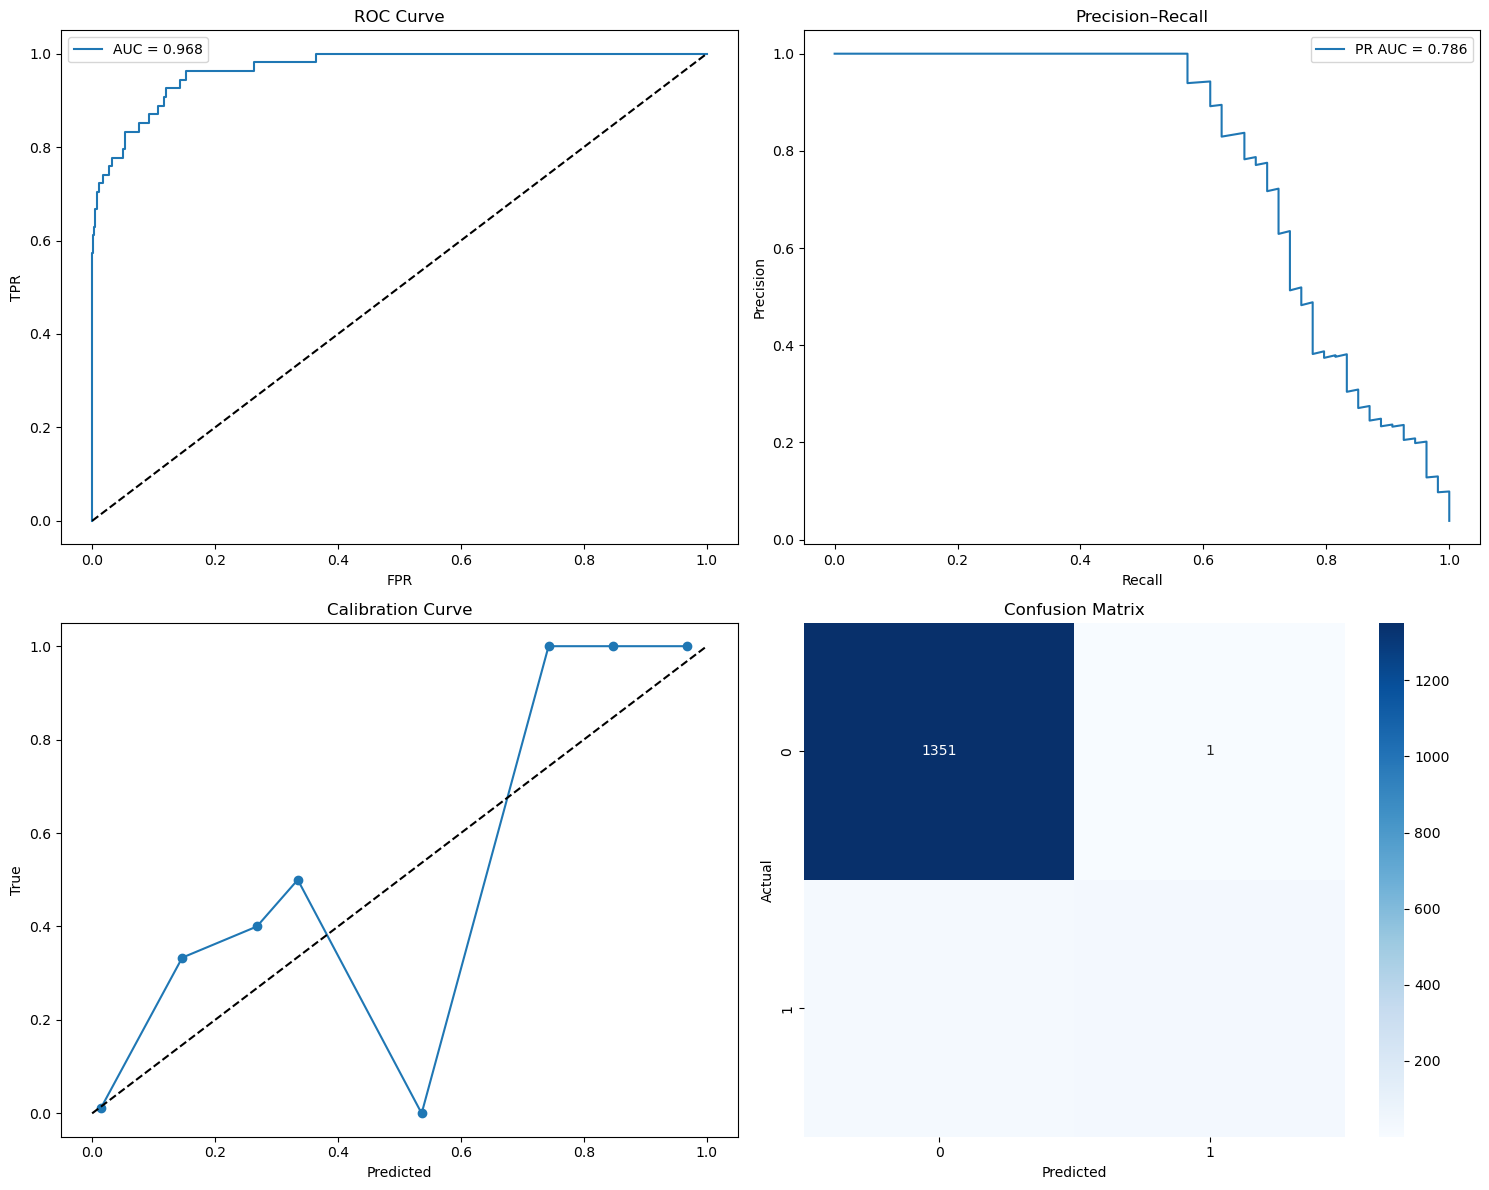

2025-04-20 20:13:53,659 | INFO | ✅ Completed: Evaluation in 0.88s
2025-04-20 20:13:53,662 | INFO | 📋 Classification Report:
              precision    recall  f1-score     support
0              0.983261  0.999260  0.991196  1352.00000
1              0.968750  0.574074  0.720930    54.00000
accuracy       0.982930  0.982930  0.982930     0.98293
macro avg      0.976005  0.786667  0.856063  1406.00000
weighted avg   0.982703  0.982930  0.980816  1406.00000
2025-04-20 20:13:53,666 | INFO | 🎯 Final Evaluation Metrics:
2025-04-20 20:13:53,667 | INFO |     ROC AUC:           0.9683
2025-04-20 20:13:53,667 | INFO |     PR AUC:            0.7864
2025-04-20 20:13:53,668 | INFO |     Optimal threshold: 0.0202
2025-04-20 20:13:53,668 | INFO | 🎉 Evaluation pipeline completed successfully in 4.60s


In [7]:
# ---------------------------------------------------------
# Code Cell 4: Final Evaluation Using Only Top Models
# ---------------------------------------------------------
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve

# 0. Configure logging globally
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger()

# Configuration
MODEL_DIR = "enhanced_models"  # Must match Code Cell 3
NFOLDS    = 5
PLOT_DIR  = "evaluation_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def load_test_data():
    logger.info("🔄 Starting: Loading processed test data from memory")
    t0 = time.time()
    # Ensure these exist in memory from Code Cell 2:
    if not all(var in globals() for var in ["X_test_full", "y_test_full"]):
        raise ValueError("X_test_full and y_test_full must be defined (from preprocessing).")
    # build a DataFrame for grouping
    test_proc = X_test_full.copy()
    test_proc["class"] = y_test_full
    logger.info(f"✅ Completed: Loading processed test data in {time.time() - t0:.2f}s")
    return X_test_full, y_test_full, test_proc

def generate_top_predictions(processed_group_dfs_test, top_models):
    logger.info("🔄 Starting: Generating base‑model predictions on test set")
    t0 = time.time()
    preds_list = []
    for grp, df_grp in processed_group_dfs_test.items():
        Xg = df_grp.drop(columns=["class"], errors="ignore")
        for model_name, _ in top_models[grp]:
            fold_preds = []
            for f in range(1, NFOLDS+1):
                path = os.path.join(MODEL_DIR, f"{grp}_{model_name}_fold_{f}.pkl")
                model = joblib.load(path)
                fold_preds.append(model.predict_proba(Xg)[:,1])
            preds_list.append(np.mean(fold_preds, axis=0).reshape(-1,1))
    stacked = np.hstack(preds_list)
    logger.info(f"✅ Completed: Generating base‑model predictions in {time.time() - t0:.2f}s")
    return stacked

def generate_evaluation_plots(y_true, y_prob, metrics):
    plt.figure(figsize=(15, 12))
    # ROC
    plt.subplot(2,2,1)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    # Precision-Recall
    plt.subplot(2,2,2)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label=f'PR AUC = {metrics["pr_auc"]:.3f}')
    plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    # Calibration
    plt.subplot(2,2,3)
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, 'o-')
    plt.plot([0,1],[0,1],'k--')
    plt.title("Calibration Curve"); plt.xlabel("Predicted"); plt.ylabel("True")
    # Confusion
    plt.subplot(2,2,4)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "full_evaluation.png"))
    plt.show()
    plt.close()

def comprehensive_evaluation(y_true, y_prob):
    logger.info("🔄 Starting: Computing evaluation metrics & plots")
    t0 = time.time()
    y_pred = (y_prob >= 0.5).astype(int)
    metrics = {
        'confusion_matrix':    confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True),
        'roc_auc':             roc_auc_score(y_true, y_prob),
        'pr_auc':              average_precision_score(y_true, y_prob),
    }
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    metrics['optimal_threshold'] = thr[np.argmax(tpr - fpr)]
    generate_evaluation_plots(y_true, y_prob, metrics)
    logger.info(f"✅ Completed: Evaluation in {time.time() - t0:.2f}s")
    return metrics

def main():
    logger.info("🚀 Starting evaluation pipeline")
    t_pipeline = time.time()

    # 1) Load from memory
    X_test, y_test, test_proc = load_test_data()

    global processed_group_dfs_test
    logger.info("🔄 Starting: Using processed test data (no NaNs) from preprocessing")

    # 3) Base-model stacking
    stacked = generate_top_predictions(processed_group_dfs_test, top_models)

    # 4) Meta-model final predictions
    logger.info("🔄 Starting: Meta‑model final predictions")
    t0 = time.time()
    meta = joblib.load(os.path.join(MODEL_DIR, "stacking_meta_model.pkl"))
    final_probs = meta.predict_proba(stacked)[:,1]
    logger.info(f"✅ Completed: Meta‑model final predictions in {time.time() - t0:.2f}s")

    # 5) Compute metrics & plots
    metrics = comprehensive_evaluation(y_test, final_probs)

    report_df = pd.DataFrame(metrics['classification_report']).transpose()
    logger.info("📋 Classification Report:\n" + report_df.to_string())
    # 6) Save & log final results
    results_df = pd.DataFrame({
        'true_label':      y_test,
        'predicted_prob':  final_probs,
        'predicted_label': (final_probs >= metrics['optimal_threshold']).astype(int)
    })
    results_df.to_csv(os.path.join(PLOT_DIR, "final_predictions.csv"), index=False)

    logger.info("🎯 Final Evaluation Metrics:")
    logger.info(f"    ROC AUC:           {metrics['roc_auc']:.4f}")
    logger.info(f"    PR AUC:            {metrics['pr_auc']:.4f}")
    logger.info(f"    Optimal threshold: {metrics['optimal_threshold']:.4f}")
    logger.info(f"🎉 Evaluation pipeline completed successfully in {time.time() - t_pipeline:.2f}s")

if __name__ == "__main__":
    main()


In [4]:
# ---------------------------------------------------------
# Code Cell 5: Quick Base‐Model Evaluation without retraining
# ---------------------------------------------------------
import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    f1_score,
    log_loss,
    brier_score_loss
)
import joblib

MODEL_DIR = "enhanced_models"
NFOLDS    = 5

# processed_group_dfs_test: dict[group_name] → DataFrame with columns [..., "class"]
# y_test_full: full‐length Series of true labels in original test order

# 1) Prepare a container for each classifier
base_models = ["XGBoost","GBDT","AdaBoost","RandomForest","LightGBM"]
# We'll build a dict of arrays: preds[model] = length‑N test‐set probability vector
preds = {m: np.zeros(len(y_test_full)) for m in base_models}

# 2) For each model, for each group, load all folds, average their proba, and slot into preds[m]
for m in base_models:
    for grp, df_grp in processed_group_dfs_test.items():
        # indices of this group in the full test set
        idx = df_grp.index
        
        # collect per‑fold probabilities
        fold_probs = []
        for f in range(1, NFOLDS+1):
            path = os.path.join(MODEL_DIR, f"{grp}_{m}_fold_{f}.pkl")
            mdl  = joblib.load(path)
            Xg   = df_grp.drop(columns=["class"], errors="ignore")
            fold_probs.append(mdl.predict_proba(Xg)[:,1])
        # average across folds
        avg_prob = np.mean(fold_probs, axis=0)
        
        # place into the correct slots in the full test‑set vector
        preds[m][idx] = avg_prob

# 3) Compute all six metrics for each model
results = []
for m in base_models:
    p = preds[m]
    y_pred = (p >= 0.5).astype(int)
    res = {
        "Method":     "Our Method",
        "Base":       m if m!="RandomForest" else "RF",
        "ACC":        accuracy_score(y_test_full, y_pred),
        "BA":         balanced_accuracy_score(y_test_full, y_pred),
        "AUC":        roc_auc_score(y_test_full, p),
        "F‑score":    f1_score(y_test_full, y_pred),
        "Log loss":   log_loss(y_test_full, np.vstack([1-p, p]).T),
        "Brier":      brier_score_loss(y_test_full, p)
    }
    results.append(res)

# 4) Turn into a DataFrame and print LaTeX
df = pd.DataFrame(results)
print(df.to_latex(index=False, float_format="%.5f",
      columns=["Method","Base","ACC","BA","AUC","F‑score","Log loss","Brier"]))


\begin{tabular}{llrrrrrr}
\toprule
    Method &     Base &     ACC &      BA &     AUC &  F‑score &  Log loss &   Brier \\
\midrule
Our Method &  XGBoost & 0.96159 & 0.50000 & 0.62351 &  0.00000 &   0.15972 & 0.03659 \\
Our Method &     GBDT & 0.96088 & 0.49963 & 0.59557 &  0.00000 &   0.16318 & 0.03701 \\
Our Method & AdaBoost & 0.96159 & 0.50000 & 0.62129 &  0.00000 &   0.50978 & 0.15998 \\
Our Method &       RF & 0.96159 & 0.50000 & 0.58905 &  0.00000 &   0.15901 & 0.03634 \\
Our Method & LightGBM & 0.96159 & 0.50000 & 0.61467 &  0.00000 &   0.16443 & 0.03699 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2224182/1829404359.py:66: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, float_format="%.5f",
